# Generative Adversarial Networks

                            Valentyn Gerushta, Léane Salais

Tâche de génération avec un GAN convolutionnel, principalement sur la base CelebA.  

https://thispersondoesnotexist.com/


## Libraries

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Default hyperparameters

Define the hyperparameters. You can play with those later.

In [2]:
## Choosing the dataset (setting one of these to True)
celebA64 = True
celebA = False
cifar = False 
restrict = True # Choosing a class in CIFAR

## Data loading
workers = 4 # Number of workers for dataloader (/!\ set to 4 when you're done debugging)
if cifar and restrict: batch_size=128
else: batch_size = 256 # Images per batch

## Architecture
nz = 100 # Size of z latent vector (i.e. size of generator input)
if celebA64:
  ndf = 64 # Base size of feature maps in discriminator
  ngf = 64 # Base size of feature maps in generator
else:
  ndf = 32
  ngf = 32

## Optimization
lrD = 0.0002 # Learning rate for the discriminator
lrG = 0.0002 # Learning rate for the generator
beta1G = 0.5 # Momentum beta1 for the discriminator
beta1D = 0.5 # Momentum beta1 for the generator

## Training
nb_update_D = 1 # Number of sub-steps of discriminator optim. at each step
nb_update_G = 1 # Number of sub-steps of generator optim. at each step
steps = 8000 # Number of global steps in the training loop
nb_epochs = 18 # Number of epochs, leave "None" if you want to set the number of "steps" (i.e. batches)

# Decide which device we want to run this on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Datasets

Download and load the datasets (CelebA, CelebA64, CIFAR-10). 

In [3]:
%%sh
if ! [ -d "/tmp/celeba/img_align_celeba64" ] ; then
    mkdir /tmp/celeba64
    cd /tmp/celeba64
    wget http://webia.lip6.fr/~douillard/rdfia/celeba64.zip
    unzip celeba64.zip
fi

if ! [ -d "/tmp/celeba/img_align_celeba" ] ; then
    mkdir /tmp/celeba
    cd /tmp/celeba
    wget https://github.com/cdancette/deep-learning-polytech-tp6-7/releases/download/celeba/celeba.zip
    unzip celeba.zip
fi

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
196700K .......... .......... .......... .......... .......... 66% 65.8M 5s
196750K .......... .......... .......... .......... .......... 66%  132M 5s
196800K .......... .......... .......... .......... .......... 66%  121M 5s
196850K .......... .......... .......... .......... .......... 66% 14.3M 5s
196900K .......... .......... .......... .......... .......... 66% 94.6M 5s
196950K .......... .......... .......... .......... .......... 66% 76.5M 5s
197000K .......... .......... .......... .......... .......... 66% 11.5M 5s
197050K .......... .......... .......... .......... .......... 66% 56.9M 5s
197100K .......... .......... .......... .......... .......... 66% 73.5M 5s
197150K .......... .......... .......... .......... .......... 66% 95.8M 5s
197200K .......... .......... .......... .......... .......... 66%  103M 5s
197250K .......... .......... .......... .......... .......... 66%  109M 5s
197300K ..

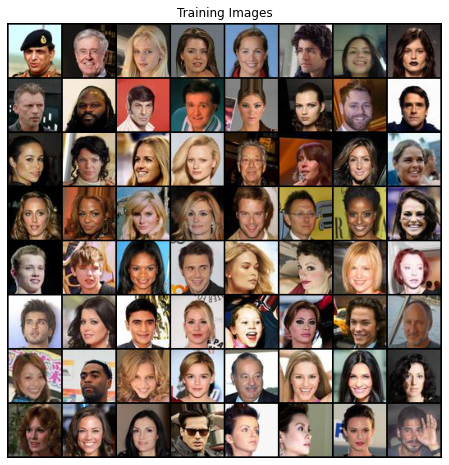

In [4]:
# Loading CIFAR-10 using torchvision.datasets
if cifar:
  dataset = dset.CIFAR10('./', transform=transforms.Compose([transforms.ToTensor(),
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True)
  if restrict:
    # Limiting the data to birds only
    exclusive = np.where(np.array(dataset.targets)==2)[0]
    dataset.data = dataset.data[list(exclusive)]
    dataset.targets = torch.ones_like(torch.Tensor(exclusive))*2

# For CelebA(XX), we can use an image folder dataset the way we have it setup.
elif celebA:
  dataset = dset.ImageFolder(root="/tmp/celeba",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
elif celebA64:
  dataset = dset.ImageFolder(root="/tmp/celeba64",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader anyway
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

# Plot a few training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
if nb_epochs is None:
    nb_epochs = (steps * batch_size) / (nb_update_D * len(dataset))
else:
    steps = int(nb_epochs * nb_update_D * len(dataset) / batch_size)
print("Doing %.1f epochs in %d steps" % (nb_epochs, steps))

Doing 18.0 epochs in 14245 steps


## Model architectures

Define the generator and discriminator and clip them together.  
See https://arxiv.org/abs/1511.06434 (Radford, A., Metz, L., Chintala, S.)


### Discriminator

Input: Image $x \in \mathbb{R}^{32\times 32\times 3}$  
Output: "Real" image probability $\in [0,1]$

* Convolution (`1*ndf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* LeakyReLU ($\alpha = 0.2$)
* Convolution (`2*ndf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* LeakyReLU ($\alpha = 0.2$)
* Convolution (`4*ndf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* LeakyReLU ($\alpha = 0.2$)
* Convolution (1 filter, kernel 4, stride 1, padding 0, no bias)
* Sigmoid activation

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        if celebA64: 
          # Another architecture -- additional layer -- is needed to deal with 64x64 images.
          self.model = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(ndf, 2*ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2*ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(2*ndf, 4*ndf,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4*ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(4*ndf, 8*ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8*ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(8*ndf, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
          )
        else:
          # The model given above is tailored for 32x32 images.
          self.model = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(ndf, 2*ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2*ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(2*ndf, 4*ndf,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4*ndf),
            nn.LeakyReLU(0.2),

            nn.Conv2d(4*ndf, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
          )
    def forward(self, input):
        return self.model(input)

### Generator

Input: Random "noise" $z \in \mathbb{R}^{\text{nz}}$  
Output: Generated image $\tilde x \in \mathbb{R}^{32\times 32\times 3}$

* Convolution Transpose (`4*ngf` filters, kernel 4, stride 1, padding 0, no bias)
* Batch Norm 2D
* ReLU
* Convolution Transpose (`2*ngf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* ReLU
* Convolution Transpose (`1*ngf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* ReLU
* Convolution Transpose (3 filters, kernel 4, stride 2, padding 1, no bias)
* Tanh activation

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        if celebA64: # Same.
          self.model = nn.Sequential(
            nn.ConvTranspose2d(nz,8*ngf,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(8*ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(8*ngf,4*ngf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(4*ngf,2*ngf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(2*ngf,ngf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
          )
        else:
          self.model = nn.Sequential(
            nn.ConvTranspose2d(nz,4*ngf,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(4*ngf,2*ngf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(2*ngf,ngf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
          )
    def forward(self, input):
        return self.model(input)

### Building the GAN

Linking both units.

In [8]:
# Create the models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models
print(netG)
print(netD)

# Model shape testing
z = torch.zeros(10, nz, 1, 1).to(device)
x = torch.zeros(10, 3, ndf, ngf).to(device)
assert netG(z).shape == x.shape
assert netD(x).shape == (10,1,1,1)
print("\033[1mand the shapes are fine !\033[0m")

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): 

## Preparing the training

### Optimization

Here we will define:
* The criterion that will be used to train the discriminator, and indirectly the generator. We use binary cross-entropy.
* The optimizers of both models. We will use the Adam optimizer.

In [9]:
# Create the criterion function that will take (y_hat, y) as input
criterion = nn.BCELoss()

# Setup Adam optimizers for D and G
optimizerD = optim.Adam(netD.parameters(),lrD,betas=(beta1D,0.999)) # take netD.parameters(), use the right lr and beta1
optimizerG = optim.Adam(netG.parameters(),lrG,betas=(beta1G,0.999)) # same for G

### Data format / batch creation functions

We need:
* A prior $P(z)$ function that we use to sample random "noise". We will use a Gaussian distribution.
* A function to load a batch of real images in memory while training the model.
* A function to sample fake images from the current distribution that G is learning.

In [10]:
# Prior P(z). Returns a Gaussian random tensor of shape (batch_size, nz, 1, 1)
def get_noise(batch_size):
    noise = torch.randn(batch_size,nz,1,1)
    return noise.to(device)

fixed_noise = get_noise(196) # Create a fixed random vector sampled from a Gaussian, will be used for train viz
real_label = 1
fake_label = 0
iterator = iter(dataloader)

# Returns a batch of real images from the dataset (iterates infinitely on the dataset)
def get_batch_real():
    global iterator
    try:
        x_real = next(iterator)[0].to(device)
    except:
        iterator = iter(dataloader)
        x_real = next(iterator)[0].to(device)
    y_real = torch.full((x_real.size(0),), real_label, device=device,dtype=torch.float32)
    return x_real, y_real

# Returns a batch of generated images and training targets y_fake
# Note that the targets y_fake will be different depending on train_G (True or False)
# -> train_G : whether the generator is working on it or not
def get_batch_fake(train_G=False):
    z = get_noise(batch_size)
    # Generate images from z
    x_fake = netG(z)
    # Create targets, depends on train_G
    if train_G: y_fake = torch.full((x_fake.size(0),),real_label,device=device, dtype=torch.float32)
    else:       y_fake = torch.full((x_fake.size(0),),fake_label,device=device, dtype=torch.float32) 
    return x_fake, y_fake

## Launching the training

### Training loop

In [11]:
img_list = []
G_losses = []
D_losses = []

for i in range(steps):
    ########
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    for _ in range(nb_update_D):
        netD.zero_grad()
        # Create batches of real and generated images 
        x_real, y_real = get_batch_real()
        x_fake, y_fake = get_batch_fake()
        # Forward : ask D about them
        y_hat_real = netD(x_real).view(-1) 
        y_hat_fake = netD(x_fake.detach()).view(-1) 
        # Evaluate its performance
        real_loss = criterion(y_hat_real,y_real)
        fake_loss = criterion(y_hat_fake,y_fake)
        # Summing criteria from real and fake samples
        errD = real_loss+fake_loss 
        # Backward
        errD.backward()
        optimizerD.step()
        # Compute / save metrics
        avg_output_for_real = y_hat_real.mean().item()
        avg_output_for_fake = y_hat_fake.mean().item()    
        D_losses.append(errD.item())

    ########
    # Update G network: maximize log(D(G(z)))
    for _ in range(nb_update_G):
        netG.zero_grad()
        # Forward + backward
        x_fake, y_fake = get_batch_fake(True) 
        # Ask D for its opinion
        y_hat = netD(x_fake).view(-1)
        errG = criterion(y_hat,y_fake)
        errG.backward()
        optimizerG.step()
        # Compute / save metrics
        G_losses.append(errG.item())
        
    ########
    # Logs
    if i % 25 == 0:
        print('[%5d/%5d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
              % (i, steps, errD.item(), errG.item(), avg_output_for_real, avg_output_for_fake))
    if i % 100 == 0:
        with torch.no_grad():
            # Ask G for a batch of fakes
            x_fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(x_fake, padding=2, normalize=True, nrow=14))
        plt.figure(figsize=(15,15))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Display training evolution

In [12]:
# Show generations
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('GANceleb64suite.mp4')
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

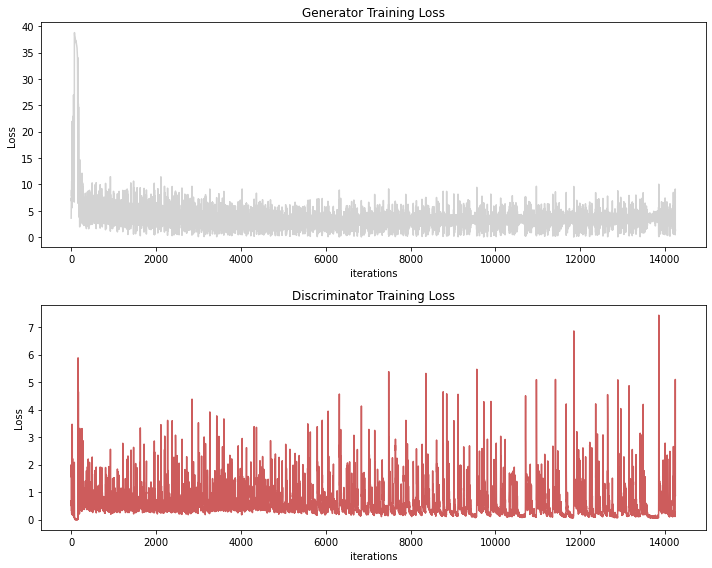

In [13]:
# Loss evolution
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Generator Training Loss")
plt.plot(G_losses, color='lightgrey')
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.subplot(2,1,2)
plt.title("Discriminator Training Loss")
plt.plot(D_losses, color='indianred')
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.tight_layout()
plt.savefig('GANceleb64suite.png')
plt.show()

## Extra test: interpolation

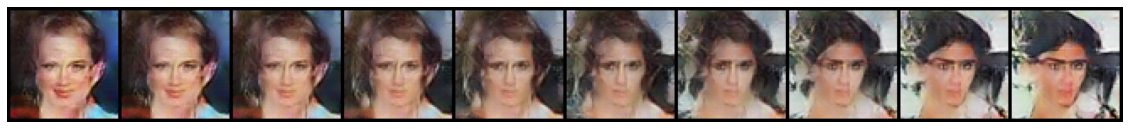

In [149]:
def interpolateGAN(n_steps=10):
  # Sample two noise vectors 
  p1 = torch.randn(1,nz,1,1).to(device)
  p2 = torch.randn(1,nz,1,1).to(device)

  # Interpolate 
  alli = []
  ratios = np.linspace(0, 1, num=n_steps)
  vectors = []
  for ratio in ratios:
    v = (1.0-ratio)*p1 + ratio*p2
    vectors.append(v)
  vectors = torch.cat(vectors)

  # Generate on the new vectors using the model you've just learnt
  with torch.no_grad():
    x_fake = netG(vectors).detach().cpu()

  # Show the images 
  alli.append(vutils.make_grid(x_fake, normalize=True, nrow=10))
  plt.figure(figsize=(20,10))
  plt.imshow(np.transpose(alli[-1],(1,2,0)))
  plt.axis("off")
  plt.show()

  return alli, p1, p2
 
interpolated, p1, p2 = interpolateGAN()